# Analyse Customer Behaviour in a Multi Category e-Commerce Website
The dataset contains customer behaviour data of a large multi category e-commerce website. The customer behaviour is reflected in the `event_type` field which is either view, cart or purchase. Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users. This exercise uses the 2019 October dataset published in Kaggle https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store. The dataset originally collected from Open CDP https://rees46.com/en/open-cdp. 

The selected dataset is approximately 5Gb in volume which makes data processing a difficult in our usual RStudio or Colab environment. Therefore, we need to move into a big data technology to process this dataset. In this exercise, we run the exerecise in a Spark Cluster run on a Cloud environment. We use Jupyter Notebook as our IDE and connect to the Spark Cluster using Python (`pyspark`). The exercise first connect to the Spark cluster, extract the data which is stored in HDFS and then run several descriptive analytics to understand the customer behaviour.

## 1. Spark configuration in `pyspark`

In [5]:
import socket
import pyspark
from pyspark.sql import SparkSession

hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)
conf = pyspark.SparkConf()
spark = SparkSession.builder.master("spark://spark-spark-master-svc:7077") \
.config("spark.submit.deployMode", "client") \
.config("spark.driver.port","7077") \
.config("spark.driver.host",ip) \
.config("spark.kubernetes.driver.pod.name ", "spark-spark-master-0") \
.config("spark.kubernetes.container.image", "gcr.io/cloud-marketplace/google/spark:3.3.0-20220703-150808") \
.config("spark.kubernetes.pyspark.pythonVersion", "3.9") \
.config("spark.executor.memory", '3g') \
.getOrCreate()
spark

## 2. Create schema and read data
It is recommended to create a Spark schema before read data to a Spark dataframe. A schema validates the type of data fields we import from HDFS and whether the data point is nullable or not. You can find the available Spark data types on https://spark.apache.org/docs/latest/sql-ref-datatypes.html.

In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import col,struct,when
schema = StructType().add('event_time', TimestampType(),True) \
                    .add('event_type',StringType(),True) \
                    .add('product_id', IntegerType(),True) \
                    .add('category_id', StringType(),True) \
                    .add('category_code', StringType(), True) \
                    .add('brand', StringType(),True) \
                    .add('price', FloatType(),True) \
                    .add('user_id', IntegerType(),True) \
                    .add('user_session', StringType(),True)
behaviour = spark.read.schema(schema).csv('hdfs://hadoop-hadoop-hdfs-nn:9000/data/behaviour_oct.csv', header=True, 
                            multiLine=True, escape="\"")
behaviour.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



## 3. Check the dataset
You can count the total number of records and display first few records to check whether Spark dataframe is successfully created.

In [7]:
behaviour.count()

42448764

In [4]:
behaviour.show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:04|      view|   1004237|2053013555631882655|electr

## 4. Run `pyspark` query 
Spark dataframe has number of data manipulation methods available to run queries. These methods interprets these methods to Spark SQL queries. Query results can be converted to pandas dataframe which allows you to process the query result as a python pandas dataframe.

The following query counts the number of records by `event_type`.

In [9]:
import pandas as pd
from pyspark.sql import *
event_type = behaviour.groupby('event_type').count().toPandas()
event_type

,event_type,count
0,purchase,742849
1,view,40779399
2,cart,926516


## Exercise 01
Using the Spark dataframe, run the following queries.

    1. Total value of customer behaviour by event type.
    2. Top 10 brands purchased by value
    3. Top 10 brands purchased by volume

In [10]:
event_value = behaviour.groupby('event_type').agg({'price': 'sum'}).toPandas()
event_value

,event_type,sum(price)
0,purchase,2.299575e+08
1,view,1.178462e+10
2,cart,3.092988e+08


In [13]:
top_brands_by_value = behaviour.filter('event_type = "purchase"').groupby('brand').agg({'price': 'sum'}).toPandas()
top_brands_by_value.sort_values(['sum(price)'],ascending=[False]).head(10)

,brand,sum(price)
282,apple,1.112093e+08
997,samsung,4.640753e+07
1862,xiaomi,9.194033e+06
404,None,8.540601e+06
1381,huawei,4.883422e+06
890,acer,3.576719e+06
858,lg,3.387888e+06
1162,lucente,3.124113e+06
859,sony,2.478197e+06
734,oppo,2.412960e+06


In [14]:
top_brands_by_volume = behaviour.filter('event_type = "purchase"').groupby('brand').agg({'product_id': 'count'}).toPandas()
top_brands_by_volume.sort_values(['count(product_id)'],ascending=[False]).head(10)

,brand,count(product_id)
997,samsung,172896
282,apple,142873
404,None,58214
1862,xiaomi,56616
1381,huawei,23501
1162,lucente,11578
734,oppo,10891
109,cordiant,10551
858,lg,8727
890,acer,6882


## Exercise 02

The `category_code` variable includes the product category and sub-categories deliemeted by a `.`. Using a string manipulation, extract the following query results.

1. Extract the main category of the purchased items with the price
2. Total value and volume of purchased items by the main category
3. Top 10 product categories by value
4. Top 10 product categories by volume


In [15]:
from pyspark.sql.functions import split
categories = behaviour.filter('event_type = "purchase"').select(split('category_code','\.').getItem(1).alias('categories'), 'product_id', 'price').toPandas()
categories

,categories,product_id,price
0,smartphone,1004856,130.759995
1,smartphone,1002532,642.690002
2,None,5100816,29.510000
3,bathroom,13800054,54.419998
4,audio,4804055,189.910004
...,...,...,...
742844,None,26402784,102.449997
742845,tools,47500017,20.590000
742846,smartphone,1003306,577.890015
742847,smartphone,1004240,1054.599976


In [16]:
import numpy as np
category_master = categories.groupby('categories').agg(Value=('price',np.sum), Volume=('product_id',np.count_nonzero))
category_master.head()

,Value,Volume
categories,,
accessories,1.274032e+06,10620
audio,4.151606e+06,35592
bag,5.315553e+04,1253
bathroom,2.029459e+04,245
bedroom,3.849862e+05,2499


In [17]:
category_master.sort_values(['Value'],ascending=[False]).head(10)

,Value,Volume
categories,,
smartphone,1.570496e+08,338018
kitchen,1.071286e+07,50022
notebook,8.979887e+06,15590
video,8.460468e+06,21647
clocks,4.818306e+06,17906
audio,4.151606e+06,35592
environment,2.320568e+06,18074
tablet,1.610974e+06,5603
accessories,1.274032e+06,10620


In [18]:
category_master.sort_values(['Volume'],ascending=[False]).head(10)

,Value,Volume
categories,,
smartphone,1.570496e+08,338018
kitchen,1.071286e+07,50022
audio,4.151606e+06,35592
video,8.460468e+06,21647
environment,2.320568e+06,18074
clocks,4.818306e+06,17906
notebook,8.979887e+06,15590
accessories,1.274032e+06,10620
tools,9.315925e+05,7814


## Exercise 03
The dataset includes items viewed by the users. This can be identified using the `event_type`. The company wants to analyse the daily view pattern during the month. First we need to generate the date from the timestamp value. Then the company requires us to generate the following query results.

1. Create daily view pattern of apple products
2. Visualise the timeseries using a line chart
3. Compare the view patterns of apple vs samsung
4. Compare the two frequency distributions

In [20]:
from pyspark.sql.functions import *
views = behaviour.withColumn('date', to_date('event_time'))
views.show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|      date|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+----------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|2019-10-01|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|2019-10-01|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|2019-10-01|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|2019

In [21]:
views_by_brand = views.groupby('brand','date').count()
apple_views = views_by_brand.filter('brand="apple"').drop('brand').toPandas().sort_values(['date'])
apple_views.head()

,date,count
24,2019-10-01,128012
30,2019-10-02,124698
0,2019-10-03,124002
6,2019-10-04,159162
16,2019-10-05,142097


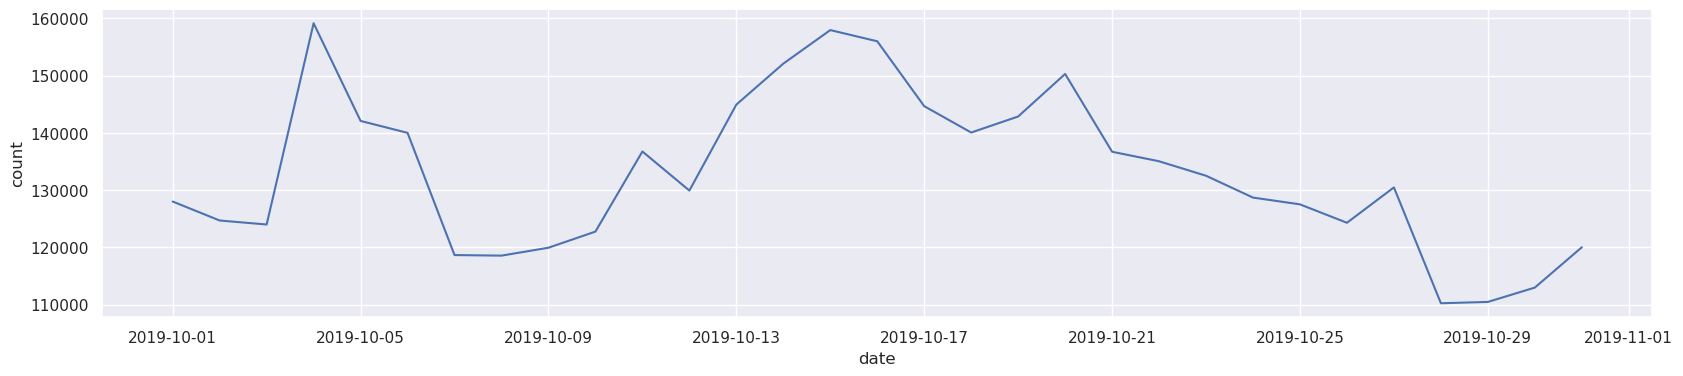

In [24]:
import seaborn as sns
sns.lineplot(apple_views,x="date",y="count")
sns.set(rc={'figure.figsize':(20,10)})

In [25]:
apple_vs_samsung = views_by_brand.filter('brand="apple" OR brand="samsung"').toPandas().sort_values(['date'])
apple_vs_samsung.head()

,brand,date,count
52,apple,2019-10-01,128012
33,samsung,2019-10-01,145737
61,apple,2019-10-02,124698
42,samsung,2019-10-02,147580
49,samsung,2019-10-03,146379


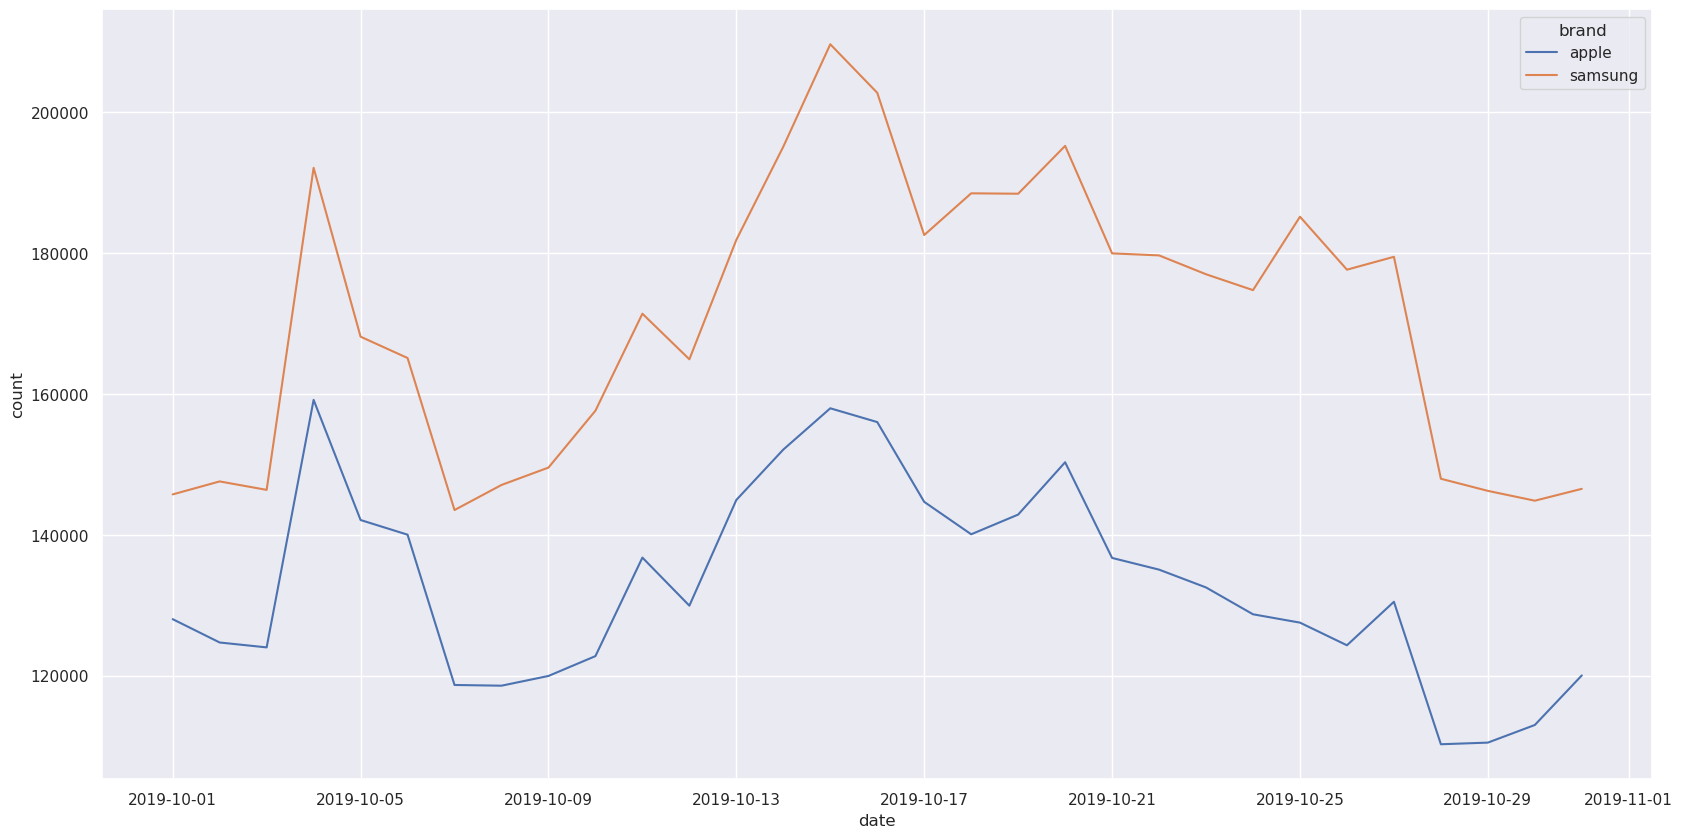

In [28]:
import seaborn as sns
sns.lineplot(apple_vs_samsung,x="date",y="count", hue="brand")
sns.set(rc={'figure.figsize':(30, 10)})

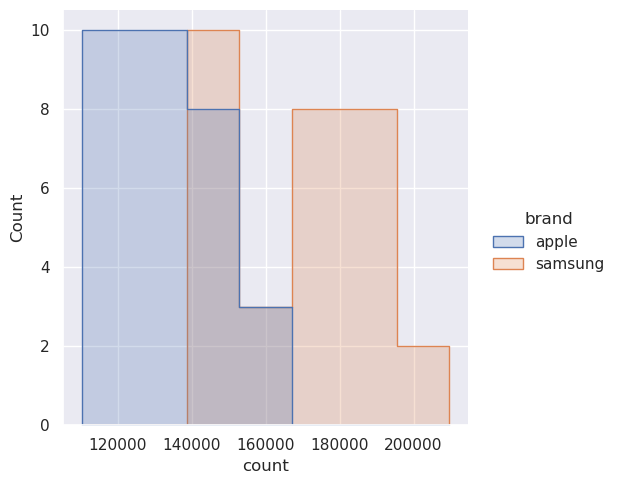

In [34]:
sns.displot(apple_vs_samsung, x="count", hue="brand", element="step")
sns.set(rc={'figure.figsize':(40,20)})

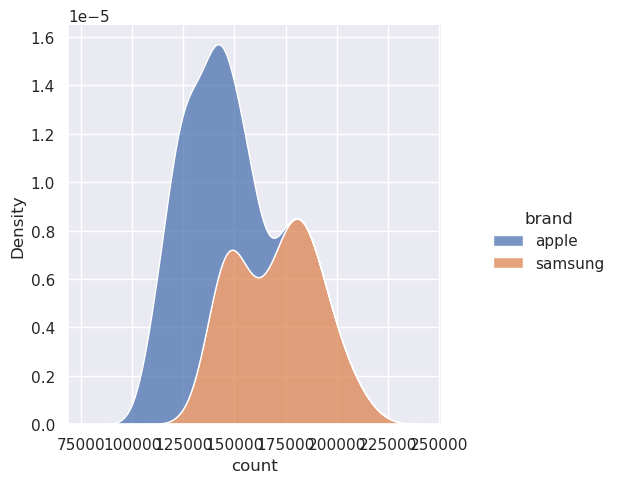

In [35]:
sns.displot(apple_vs_samsung, x="count", hue="brand", kind='kde', multiple="stack")
sns.set(rc={'figure.figsize':(40,20)})

## 5. Close Spark connection

In [8]:
spark.stop()